<a href="https://colab.research.google.com/github/Wpert/numerics/blob/main/numericsSOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Описывать подробно генерацию рандомной матрицы с единичным рещением не буду, а вот сам метод верхней релаксации думаю стоит описать подробнее.

Теория
---
Дана система уравнений $Ax = b$, вида:
<!-- \begin{vmatrix}
  М & 0 & 0\\
  0 & И & Ф\\
  0 & -И & 1
\end{vmatrix} -->


\begin{equation*}
 \begin{cases}
   a_{11} x_1 + a_{12} x_2 + \dots + a_{1n} x_n &= b_1\\
   a_{21} x_1 + a_{22} x_2 + \dots + a_{2n} x_n &= b_2\\
   \vdots \\
   a_{n1} x_1 + a_{n2} x_2 + \dots + a_{nn} x_n &= b_n\\
 \end{cases}
\end{equation*}

Соответственно требуется найти решение этой системы уравнений. И не просто найти, а итерационным методом найти с какой-либо точностью.

Ещё до моего рождения умные люди придумали метод Зейделя, а на его основе метод нижней / верхней релаксации.

В подробности вдаваться не хочу, потому сразу к делу. Буду доказывать будто этот медот уже всем известен и ничего указывать не буду.

$$A = L  + D + U,$$

где $A = \begin{pmatrix}
            a_{11} & a_{22} & \dots & a_{1n} \\
            a_{21} & a_{22} & \dots & a_{2n} \\
            \vdots & \vdots &       & \vdots \\
            a_{n1} & a_{n2} & \dots & a_{nn} \\
\end{pmatrix},
L = \begin{pmatrix}
            0      & 0      & \dots & 0 \\
            a_{21} & 0      & \dots & 0 \\
            \vdots & \vdots &       & \vdots \\
            a_{n1} & a_{n2} & \dots & a_{nn} \\
\end{pmatrix}$

$U = \begin{pmatrix}
            0      & a_{22} & \dots & a_{1n} \\
            0      & 0      & \dots & a_{2n} \\
            \vdots & \vdots &       & \vdots \\
            0      & 0      & \dots & 0 \\
\end{pmatrix},
D = \begin{pmatrix}
            a_{11} & 0      & \dots & 0 \\
            0      & a_{22} & \dots & 0 \\
            \vdots & \vdots &       & \vdots \\
            0      & 0      & \dots & a_{nn} \\
\end{pmatrix}.$

Тогда уравнение можно переписать в следующем виде:

$$ Ax = b $$
$$ (L + D + U) x = b $$
$$ ω(L + D + U) x = ωb $$
$$ ωLx = ωb - ωDx - ωUx $$
$$ Dx + ωLx = ωb - ωUx - ωDx + Dx $$
$$ (D + ωL) x = ωb - [ωU - (ω - 1)D] x \tag{1} $$

И, насколько мне известно, при коэффициенте $ω > 1$ это метод верхней релаксации, а при $0 < ω < 1$ это метод нижней релаксации. Но при $\omega = 1$ этот метод переходит в точности в метод Зейделя. То есть затраты на память и асимтотическая сложность абсолютно такая же как и у метода Зейделя, но благодаря некоторой работе с дополнительной константой можно ускорить работу программы в несколько раз.

Теперь можно переписать равенство как:

$$ (D + ωL) x^{(k + 1)} = ωb - [ωU - (ω - 1)D] x^{(k)} $$
$$ x^{(k + 1)} = (D + ωL)^{-1} (ωb - [ωU - (ω - 1)D] x^{(k)}) $$

Отсюда и получим конечную формулу:
$$ x^{(k + 1)} = (1 - ω)x^{(k)}_{i} + \frac{\omega}{a_{ii}}(b_i - \sum_{j < i}a_{ij}x^{(k + 1)}_{j} - \sum_{j > i}a_{ij}x^{(k)}_{j}) $$

In [2]:
from numpy.linalg.linalg import LinAlgError
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

# Генерация рандомной матрицы с единичным решением
def GenerateRandomMtrx(N: int) -> Tuple[np.ndarray, np.ndarray]:
    Matr = np.random.randint(-20, 20 + 1, size=(N, N))
    A = np.dot(Matr.T, Matr)
    b = np.zeros((N, 1))
    for i in range(N):
        b[i] += np.sum(A[i, :])

    return (A, b)

# Рассчёт невязки
def calcResidual() -> float:
    return 0.0

def SOR_method(A: np.ndarray, b: np.ndarray) -> Tuple[List[int], List[int]]:
    MAX: int = 500 # Максимальная граница вычислений

    N = A.shape[0]
    x = np.zeros((N, 1))

    omega_list = [0.005 + 0.005 * i for i in range(400)]
    length = len(A)
    counts = [] # будем записывать количество итераций для каждого значения  omega

    for omega in omega_list: # соответственно и начнём итерироваться по каждой omegs
        times = 0
        x_0 = np.zeros((length, 1))

        x_hold = x_0 + np.ones((length, 1))
        try:
            while (np.linalg.norm(x_hold - x_0, ord=2) >= 10 ** (-5)) and (times <= MAX):
                # Условием остановки является разница между k+1 и k итерацией и максимальное число итераций
                x_hold = x_0.copy()
                x_new = x_0.copy()
                for i in range(length):
                    # В цикле считаем формулу из теоретического блока
                    x_new[i][0] = x_0[i][0] + omega * (b[i][0] - sum([A[i][j] * x_new[j][0] for j in range(i)])\
                                            - sum([A[i][j] * x_0[j][0] for j in range(i, length)])) / A[i][i]
                    x_0 = x_new.copy()
                    times += 1
        except LinAlgError:
            times = MAX

        # Записываем количество итераций цикла
        counts.append(times)

    return (omega_list, counts)

Соответственно ниже представлено применение этих функций.

Сгенерированная матрица (4, 4)


⎡494   -493  64   207 ⎤
⎢                     ⎥
⎢-493  826   314  -220⎥
⎢                     ⎥
⎢ 64   314   516   76 ⎥
⎢                     ⎥
⎣207   -220  76   829 ⎦

Сгенерированный столбец (4, 1)


⎡272.0⎤
⎢     ⎥
⎢427.0⎥
⎢     ⎥
⎢970.0⎥
⎢     ⎥
⎣892.0⎦

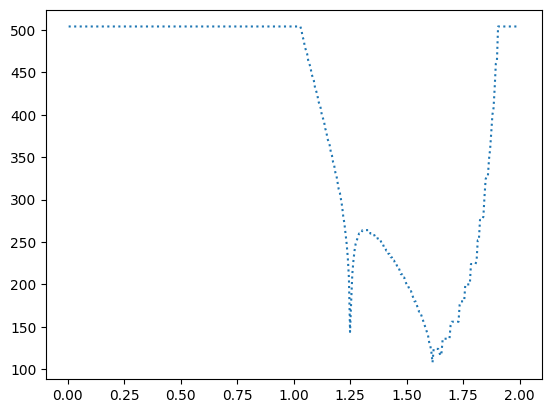

Минимальная θ = 1.615


In [5]:
from sympy import Matrix, init_printing
init_printing()
# # пример матрицы A -- 4х4
# A = np.array([[4, -1, 0, 0],
#               [-1, 4, -1, 0],
#               [0, -1, 4, -1],
#               [0, 0, -1, 3]])
# # пример столбца B
# b = np.array([[15], [10], [10], [10]])
A, b = GenerateRandomMtrx(4)

print("Сгенерированная матрица", A.shape)
display(Matrix(A))
print("Сгенерированный столбец", b.shape)
display(Matrix(b))
omega_list, counts = SOR_method(A, b)

# Рисуем зависимость между тетой и количеством итераций
plt.plot(omega_list, counts, ':')
plt.show()

min_omega = omega_list[counts.index(min(counts))]
print(f"Минимальная \u03B8 = {min_omega}")


Давайте выясним какое среднее значение $\theta$, при котором достигается наименьшее значение количества итераций метода верхней релаксации

In [ ]:
from numpy.linalg.linalg import LinAlgError
import numpy as np
import matplotlib.pyplot as plt

N: int = 5

theta_min_list = []
for operations in range(50):
  A, b = GenerateRandomMtrx(N)
  omega_list, counts = SOR_method(A, b)
  min_omega = omega_list[counts.index(min(counts))]
  theta_min_list.append(min_omega)

print(sum(theta_min_list) / len(theta_min_list))

1.107
